In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:85% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

**<font size="6" color="red">ch9. Transormers</font>**
- 인코더 층만으로 구현(입력:자연어, 출력:긍정/부정)

## 1. 패키지

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from time import time #70.1.1부터 현재까지의 밀리세컨

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

## 2. 하이퍼 파리미터 설정(이 파라미터를 바꾸면 정확도나 학습 속도에 차이남)

In [3]:
MY_WORDS  = 10000 # imdb 데이터의 단어수
MY_LENGTH = 80    # 영화평 단어수 80개만 독립변수
MY_EMBED  = 32    # Embedding layer의 결과 차원
MY_HIDDEN = 64    # LSTM의 units 차원

MY_EPOCH  = 10    # 학습 수(fit)
MY_BATCH  = 200   # batch_size(fit시 매번 데이터를 가져오는 데이터)

## 3. 데이터 불러오기

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MY_WORDS)

17464789/17464789 [==============================] - 2s 0us/step


## 4. 문자단어 -> 정수

In [5]:
word_to_id = imdb.get_word_index() # {'word':id}
id_to_word = {} #{1:'the', 3: 'a', 16816:'sonja'}
for word, value in word_to_id.items():
    id_to_word[value] = word
print(id_to_word[1])
print(id_to_word[3])

1641221/1641221 [==============================] - 0s 0us/step
the
a


In [6]:
msg = "What a wonderful movie"
msg = msg.lower().split()
# 1:리뷰시작을 알리는 숫자, 2:문자가짤려서잘못읽어옴, 3:padding처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 data :', data)
print('추정된 data :', [id_to_word.get(d-3, '???') for d in data])
print('추정된 data :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

원 후기 내용 : ['what', 'a', 'wonderful', 'movie']
encoded된 data : [1, 51, 6, 389, 20]
추정된 data : ['???', 'what', 'a', 'wonderful', 'movie']
추정된 data : ??? what a wonderful movie


## 5. 숫자영화평 -> 자연어 영화평 return 함수

In [7]:
def decoding(review_num):
    decoded = [id_to_word.get(num-3, '???') for num in review_num]
    return ' '.join(decoded)

In [8]:
print(decoding(x_train[1]), y_train[1])

??? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ??? the hair is big lots of boobs ??? men wear those cut ??? shirts that show off their ??? sickening that men actually wore them and the music is just ??? trash that plays over and over again in almost every scene there is trashy music boobs and ??? taking away bodies and the gym still doesn't close for ??? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then 0


## 6. 영화평 (입력변수)의 길이

In [9]:
def show_length(x_train):
    print('첫 20개 영화평 길이')
    print([len(x_data) for x_data in x_train[:20]])

In [10]:
# pad_sequence 전
show_length(x_train)

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177]


In [11]:
print('제일 긴 영화평 단어 길이 :', 
     max(len(x_data) for x_data in x_train))
print('제일 짧은 영화평 단어 길이 :', 
     min(len(x_data) for x_data in x_train))
print('영화평 단어 길이 중위수 :',
     np.median([len(x_data) for x_data in x_train]))

제일 긴 영화평 단어 길이 : 2494
제일 짧은 영화평 단어 길이 : 11
영화평 단어 길이 중위수 : 178.0


## 7. 모든 영화평 길이를 동일하게(MY_LENGTH=80)

In [12]:
X_train = pad_sequences(x_train,
                       padding='pre',
                       truncating='pre', # 뒷부분을 짜르고 앞부분을 남김
                       maxlen=MY_LENGTH)
X_test = pad_sequences(x_test,
                      padding='pre',
                      truncating='pre',
                      maxlen=MY_LENGTH)
show_length(X_train), show_length(X_test)

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


(None, None)

## 8. 최종 데이터 shape 확인

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

## 9. 모델 생성

In [14]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, # 10000
                   output_dim=MY_EMBED, # 32
                   input_length=MY_LENGTH)) # 80
# RNN : 입력 단어의 길이 수가 너무 길면 파리미터 업데이트 안 됨
# 개선모델1. LSTM 개선모델2. GRU
model.add(GRU(units=MY_HIDDEN,
              input_shape=(MY_LENGTH, MY_EMBED)
         ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            320000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________


## 9. 모델구현(Transformers)

In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

INPUTS = layers.Input(shape=(MY_LENGTH,)) # 80

INPUT_EMBEDDING = layers.Embedding(input_dim=MY_WORDS, # 10000
                                   output_dim=MY_EMBED)(INPUTS)# 32

# Positional Encoding
POSITIONS = tf.range(start=0,
                    limit=MY_LENGTH)
POS_ENCODING = layers.Embedding(input_dim=MY_LENGTH, output_dim=MY_EMBED)(POSITIONS)
POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING

ATTENTION_OUTPUT = layers.MultiHeadAttention(num_heads=3,
key_dim=MY_EMBED)(POS_ENC_OUTPUT,
POS_ENC_OUTPUT)
X = layers.add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = layers.BatchNormalization()(X)
# FeedForward Network
FFN = Sequential([layers.Dense(MY_HIDDEN, activation="relu"),
layers.Dense(MY_EMBED, activation="relu")])(X)
X = layers.add([FFN, X])
X = layers.BatchNormalization()(X)
# 하나의 벡터로 압축해서 Dense로 보내줌
X = layers.GlobalAveragePooling1D()(X)
X = layers.Dropout(0.1)(X)
X = layers.Dense(MY_HIDDEN, activation="relu")(X)
X = layers.Dropout(0.1)(X)
OUTPUTS = layers.Dense(2, activation="softmax")(X)
model = Model(inputs=INPUTS, outputs=OUTPUTS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 80, 32)       320000      ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 80, 32)      0           ['embedding_1[0][0]']            
 da)                                                                                              
                                                                                                  
 multi_head_attention (MultiHea  (None, 80, 32)      12608       ['tf.__operators__.add[0][0]'

## 10. 학습환경 설정 및 학습하기

In [15]:
model.compile(loss='binary_crossentropy', # 이진분류시 손실함수
             optimizer='adam',
             metrics=['acc'])
begin = time() # 70.1.1부터 현재까지의 초수
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time() # 70.1.1부터 이 시점까지의 초수
print('총 학습시간 :', (end-begin))

Epoch 1/10
100/100 [==============================] - 10s 85ms/step - loss: 0.5583 - acc: 0.6826 - val_loss: 0.3891 - val_acc: 0.8244
Epoch 2/10
100/100 [==============================] - 8s 79ms/step - loss: 0.3140 - acc: 0.8674 - val_loss: 0.3678 - val_acc: 0.8384
Epoch 3/10
100/100 [==============================] - 8s 78ms/step - loss: 0.2375 - acc: 0.9089 - val_loss: 0.3815 - val_acc: 0.8266
Epoch 4/10
100/100 [==============================] - 8s 79ms/step - loss: 0.1978 - acc: 0.9262 - val_loss: 0.4555 - val_acc: 0.8256
Epoch 5/10
100/100 [==============================] - 8s 78ms/step - loss: 0.1628 - acc: 0.9420 - val_loss: 0.4604 - val_acc: 0.8166
Epoch 6/10
100/100 [==============================] - 8s 78ms/step - loss: 0.1369 - acc: 0.9531 - val_loss: 0.5548 - val_acc: 0.8152
Epoch 7/10
100/100 [==============================] - 8s 83ms/step - loss: 0.1098 - acc: 0.9635 - val_loss: 0.6133 - val_acc: 0.8122
Epoch 8/10
100/100 [==============================] - 8s 80ms/step -

In [16]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

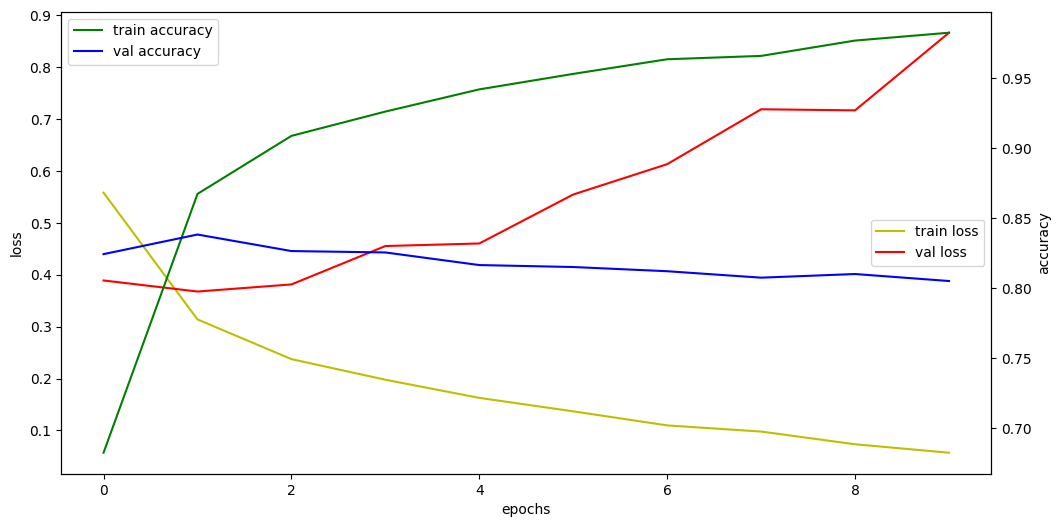

In [17]:
# 5. 모델 학습과정 시각화
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

## 11. 모델 평가

In [18]:
# pad_sequences 'post' : 75.81%
# pad_sequences 'pre' : 80.19%
# MY_LENGTH=178: 83.89%
loss, acc = model.evaluate(X_test, y_test)
print('정확도 :', acc)

782/782 [==============================] - 8s 10ms/step - loss: 0.8944 - acc: 0.7946
정확도 : 0.7946000099182129


In [19]:
# 혼동행렬, recall, precision을 위한 yhat
yhat = (model.predict(X_test, 
                      verbose=0) > 0.5).astype(np.int16).reshape(-1)
yhat

array([0, 1, 0, ..., 0, 0, 1], dtype=int16)

In [20]:
# 혼동행렬
confusion_matrix(y_test, yhat)

array([[ 9661,  2839],
       [ 2296, 10204]], dtype=int64)

In [21]:
# recall(실제 True인 것 중 True로 예측한 비율) 10238/(2262+10238)
recall_score(y_test, yhat)

0.81632

In [22]:
# precision(True로 예측한 것 중 실제값이 True인 비율) 10238/(2778+10238)
precision_score(y_test, yhat)

0.7823353522962508

## 12. 모델 사용하기

In [23]:
review = """The movie was really exciting, 
and I watched it throughout the movie hoping it wouldn't end without 
watching the clock. I strongly recommend it. 
It was even more interesting thinking that it could happen in real life. 
The main character was handsome and acted well, so my eyes were happy, 
and the story was fun @_@ㅠ.ㅠ""".lower()
import re
review = re.sub('[^a-zA-Z\'\s]', '', review)
review = review.split() # 단어 list
review = [1] + [word_to_id.get(word, -1)+3 for word in review]
print(review, len(review))

[1, 4, 20, 16, 66, 1127, 5, 13, 296, 12, 469, 4, 20, 1383, 12, 586, 130, 209, 149, 4, 5431, 13, 2303, 386, 12, 12, 16, 60, 53, 221, 536, 15, 12, 100, 593, 11, 147, 113, 4, 293, 109, 16, 2252, 5, 917, 73, 38, 61, 523, 71, 654, 5, 4, 65, 16, 253] 56


In [24]:
input_data = pad_sequences([review],
                      padding='pre',
                      truncating='pre',
                      maxlen=MY_LENGTH)
input_data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1,    4,   20,   16,   66, 1127,    5,   13,  296,
          12,  469,    4,   20, 1383,   12,  586,  130,  209,  149,    4,
        5431,   13, 2303,  386,   12,   12,   16,   60,   53,  221,  536,
          15,   12,  100,  593,   11,  147,  113,    4,  293,  109,   16,
        2252,    5,  917,   73,   38,   61,  523,   71,  654,    5,    4,
          65,   16,  253]])

In [25]:
result = (model.predict(input_data)>0.5).astype('int8').reshape(-1)
result

1/1 [==============================] - 0s 23ms/step


array([1], dtype=int8)